# Data Processing

## 1. Read all network variables

In [ ]:
import pandas as pd
import numpy as np

path = '/content/drive/MyDrive/Colab Notebooks/PhD Research/cai2015/generated_data/0422analysis.dta'

network_variables = pd.read_stata(path,convert_categoricals=False)

In [ ]:
network_variables.head()

,id,address,region,village,takeup_survey,age,agpop,educ,rice_inc,ricearea_2010,...,mean_allnetpath_out_ind,mean_1steduc_path_out_ind,mean_allnetpath_in_ind,mean_1steduc_path_in_ind,mean_allneteigenvector,mean_1steduc_eigenvector,eigenvector,indegree,path_in_ind,path_out_ind
0,1111030,fusheng21,1,fusheng,1,76.0,5.0,1.0,40.0,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1111031,fusheng21,1,fusheng,0,54.0,4.0,0.0,100.0,10.00,...,2.640000,0.0,2.507692,0.0,0.181081,0.0,0.000000,2.0,2.846154,1.600000
2,1111032,fusheng21,1,fusheng,1,67.0,2.0,2.0,60.0,10.00,...,2.433333,0.0,2.179487,0.0,0.097739,0.0,0.314172,3.0,2.538461,2.400000
3,1111034,fusheng21,1,fusheng,1,74.0,2.0,1.0,30.0,0.74,...,2.150000,0.0,2.384615,0.0,0.000000,0.0,0.132242,3.0,2.647436,2.181818
4,1111035,fusheng21,1,fusheng,1,60.0,6.0,1.0,50.0,11.00,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.002534,1.0,1.000000,2.675950


In [ ]:
network_variables.columns,network_variables.shape

(Index(['id', 'address', 'region', 'village', 'takeup_survey', 'age', 'agpop',
        'educ', 'rice_inc', 'ricearea_2010', 'disaster_loss', 'insurance_repay',
        'insurance_buy', 'disaster_prob', 'general_trust', 'male', 'default',
        'delay', 'intensive', 'info_takeup_rate', 'info_takeup_list',
        'info_none', 'understanding', 'day', 'risk_averse', 'literacy',
        'educ_good', 'reveal', 'disaster_yes', 'network_obs',
        'network_rate_preintensive', 'network_rate_presession',
        'network_rate_pretakeup', 'network_rate_presimple', 'knowledge_network',
        'friend1', 'friend2', 'friend3', 'friend4', 'friend5',
        'network_onlyone', 'network_onlytwo', 'network_twomore', 'network_yes',
        'network_twoside', 'secondnet_obs', 'network_second',
        'mean_allnetindegree', 'mean_1steduc_indegree',
        'mean_allnetpath_out_ind', 'mean_1steduc_path_out_ind',
        'mean_allnetpath_in_ind', 'mean_1steduc_path_in_ind',
        'mean_allneteigenv

## 2. Obtain network graph of mutual friendships

Load data

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PhD Research/cai2015/0422allinforawnet.dta'
df = pd.read_stata(path)

df.head()

,region,address,village,id,network_id,network_village,network_address,takeup_survey,delay,intensive,understanding,network_missname
0,3.0,xihuxinze2,xihu,33310279,99.0,xihu,xihuxinze1,NaN,NaN,NaN,NaN,0.0
1,1.0,xinlian1314,xinlian,11125310,99.0,xinlian,xinlian1314,NaN,NaN,NaN,NaN,0.0
2,2.0,fuzhouxinkanshang,fuzhou,2229114,99.0,fuzhou,fuzhouxinkanshang,NaN,NaN,NaN,NaN,0.0
3,1.0,zhangxi82,zhangxi,1114548,99.0,zhangxi,zhangxi8,NaN,NaN,NaN,NaN,0.0
4,1.0,hefeng14,hefeng,11117753,99.0,hefeng,hefeng14,NaN,NaN,NaN,NaN,0.0


Remove missing values and duplicates

In [ ]:
# Drop observations where network_missname == 1 and network_id is missing
df = df.drop(df[(df['network_missname'] == 1) & (df['network_id'].isna())].index)

# Drop observations where delay is missing
df = df.dropna(subset=['delay'])

# Find observations of df where df['id'] and df['network_id'] both exist in network_variables['id']
# Convert relevant columns to numeric, handling potential errors
network_variables['id'] = pd.to_numeric(network_variables['id'], errors='coerce')
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['network_id'] = pd.to_numeric(df['network_id'], errors='coerce')

# Filter out rows with NaN values in the ID columns
network_variables = network_variables.dropna(subset=['id'])
df = df.dropna(subset=['id', 'network_id'])

# Convert IDs to integers for comparison
network_variables['id'] = network_variables['id'].astype(int)
df['id'] = df['id'].astype(int)
df['network_id'] = df['network_id'].astype(int)

# Get unique IDs from network_variables
valid_ids = set(network_variables['id'].unique())

# Filter df
df = df[df['id'].isin(valid_ids) & df['network_id'].isin(valid_ids)]

# Find rows of df that are unique in df[['id','network_id']]
df = df.drop_duplicates(subset=['id', 'network_id'])

Construct links based on mutual friendship

In [ ]:
# Find the location of df['id'] in network_variables['id']
locations_id = []
for i in range(len(df)):
  location = network_variables[network_variables['id'] == df['id'].iloc[i]].index[0]
  locations_id.append(location)

# Find the location of df['network_id'] in network_variables['id']
locations_network_id = []
for i in range(len(df)):
  location = network_variables[network_variables['id'] == df['network_id'].iloc[i]].index[0]
  locations_network_id.append(location)

# Initialize the matrix G
G = np.zeros((len(network_variables), len(network_variables)))

# Iterate through the locations and set G[i,j] to 1
for i, j in zip(locations_id, locations_network_id):
    if i is not None and j is not None:
        G[i, j] = 1

# Drop one-sided links
for i in range(len(G)):
  for j in range(len(G)):
    if G[i,j] != G[j,i]:
      G[i,j] = 0

# Apply the Estimation Procedure

In [ ]:
import statsmodels.api as sm
from scipy.spatial import distance_matrix
from scipy.optimize import leastsq,minimize
import matplotlib.pyplot as plt
import seaborn as sns

try:
  from linearmodels.iv import IV2SLS
except ImportError:
  !pip install linearmodels
  from linearmodels.iv import IV2SLS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00


Outcome model
$$Y=\beta GY+\delta GZ + f(X)\odot Z+\epsilon$$

In [ ]:
# Filter observations: first round + (second round & no info)
filtered_network_variables = network_variables[
    (network_variables['delay'] == 0) |
    ((network_variables['delay'] == 1) & (network_variables['info_none'] == 1))]

# Drop rows of filtered_network_variables where covariates have missing values
covariates = ['delay','male','age','agpop','ricearea_2010','literacy','risk_averse','disaster_prob']
#covariates = ['age','agpop','ricearea_2010','disaster_prob'] ################################
filtered_network_variables = filtered_network_variables.dropna(subset=covariates+['understanding'])

# Obtain the indices of the surviving rows
filtered_indices = filtered_network_variables.index

# Trim the network graph accordingly
ind = network_variables.index.isin(filtered_indices)
filtered_G = G[ind,:][:,ind]

Prepare data

In [ ]:
T = filtered_network_variables['intensive']
Y = filtered_network_variables['understanding']
X = filtered_network_variables[covariates].values

V = len(filtered_G)
p = X.shape[1]
q = 5 # truncation degree of instruments

treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 20 # Kernel bandwidth
lam = 0.001 # kernel regularization term
beta_hat = 0.2 # initial beta
delta_hat = 0.5 # initial delta
parameters = [beta_hat,delta_hat]

K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),p),X[treated].reshape(int(sum(T)),p))**2/(2*sigma**2))
Y_pred = np.ones(V)*999

Run estimation algorithm

In [ ]:
GY = filtered_G@Y
GT = filtered_G@T

while True:
    Y_tilde = Y-beta_hat*GY-delta_hat*GT
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde.iloc[treated]
    KC = K@C_hat

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    iv1 = np.array([np.linalg.matrix_power(filtered_G,(k+2))@np.multiply(fx_hat,T) for k in range(q)])
    iv2 = [np.linalg.matrix_power(filtered_G,(k+2))@T for k in range(q)]
    ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = GT, # exogenous regressors
        endog = GY, # endogenous regressors
        instruments = ivs, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    delta_hat = ivreg.params.iloc[1]
    parameters = np.column_stack((parameters,ivreg.params))
    # iteration += 1
    Y_pred_new = fx_hat+beta_hat*GY+delta_hat*GT

    if np.linalg.norm(Y_pred_new - Y_pred)<0.00000001:
        print("Estimation converged")
        break
    Y_pred = Y_pred_new

Estimation converged


Examine the results

In [ ]:
beta_hat,delta_hat

(np.float64(0.10878513152849684), np.float64(-0.07898591668242828))

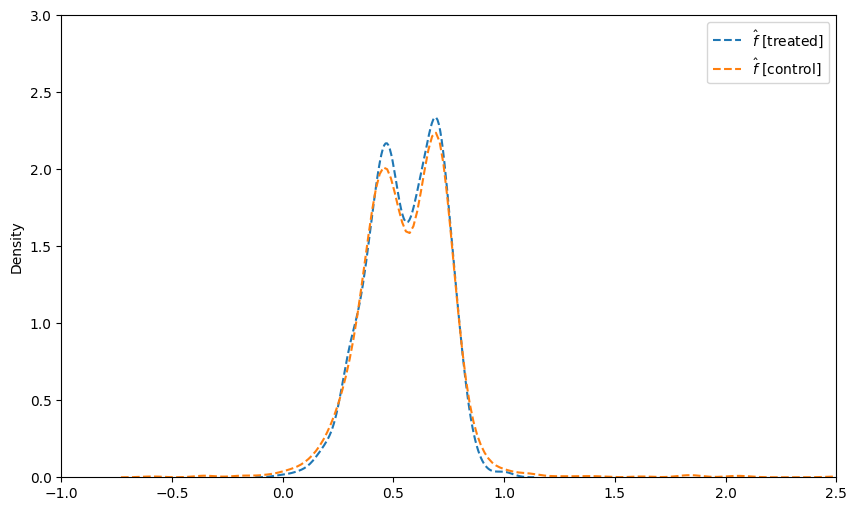

In [ ]:
d1 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d1**2/(2*sigma**2))@C_hat

plt.figure(figsize=(10, 6))
plt.xlim(-1,2.5)
plt.ylim(0,3)
sns.kdeplot(fx_hat[treated],label=r'$\hat{f}$ [treated]',linestyle='--')
sns.kdeplot(fx_hat[control],label=r'$\hat{f}$ [control]',linestyle='--')
plt.legend(loc=1)
plt.show()


Check for non-linearity

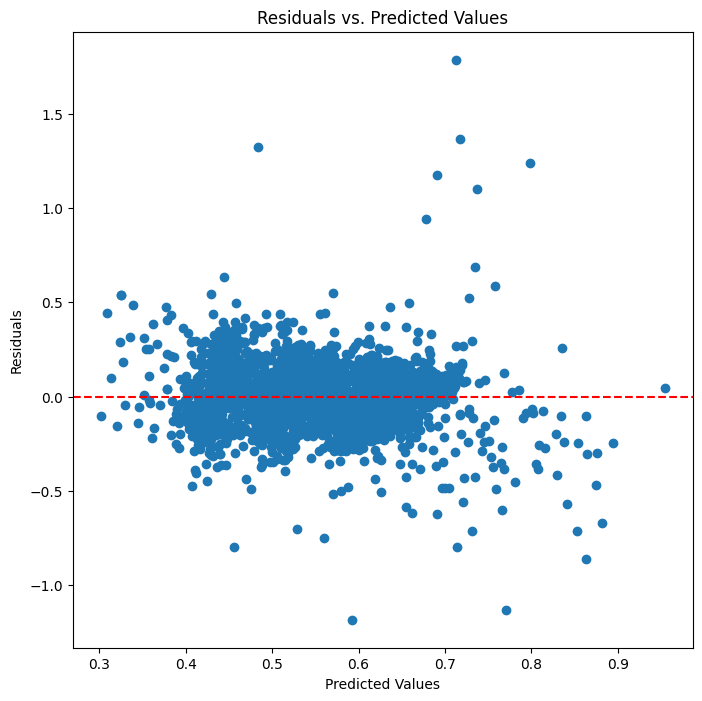

In [ ]:
X = sm.add_constant(X)  # Add a constant to the model
model = sm.OLS(fx_hat, X).fit()

residuals = fx_hat - model.fittedvalues

# Create the residual plot
plt.figure(figsize=(8, 8))
plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()


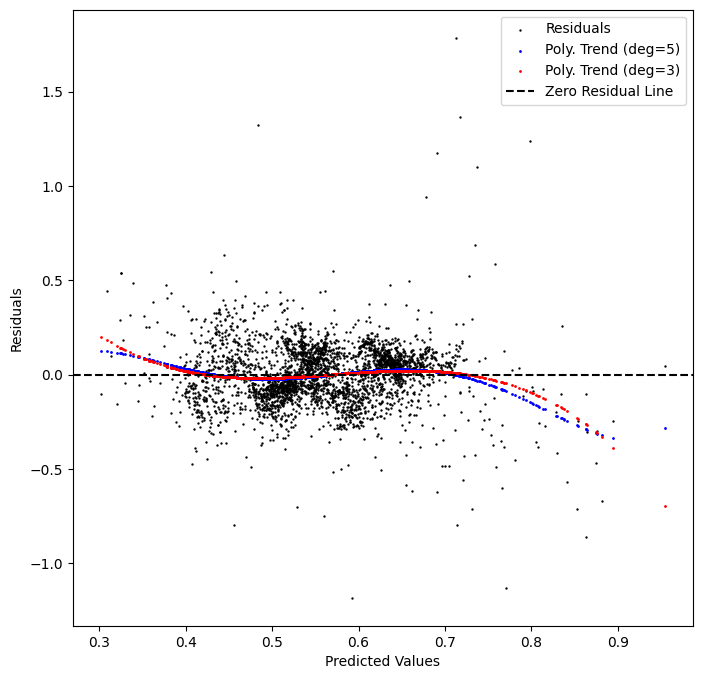

Approximate Rainbow Test Statistic: 0.03362352232282


In [ ]:
X = sm.add_constant(X)  # Add a constant to the model
model = sm.OLS(fx_hat, X).fit()

residuals = fx_hat - model.fittedvalues

# Fit a polynomial trend line to the residuals
degree = 5  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(model.fittedvalues, residuals, degree)
polynomial = np.poly1d(coefficients)
trend_line5 = polynomial(model.fittedvalues)

degree = 3  # Adjust the degree of the polynomial as needed
coefficients = np.polyfit(model.fittedvalues, residuals, degree)
polynomial = np.poly1d(coefficients)
trend_line3 = polynomial(model.fittedvalues)

# Create the residual plot with the trend line
plt.figure(figsize=(8, 8))
plt.scatter(model.fittedvalues, residuals, color='black', label="Residuals",s=0.5)
plt.scatter(model.fittedvalues, trend_line5, color='b', label=f"Poly. Trend (deg=5)",s=1)
plt.scatter(model.fittedvalues, trend_line3, color='r', label=f"Poly. Trend (deg=3)",s=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--', label="Zero Residual Line")  # Add a horizontal line at y=0
plt.legend(loc=1)
plt.show()

# Calculate the Rainbow test statistic manually
# Note: This is a simplified illustration, the actual Rainbow test is more complex

# Calculate the sum of squared residuals for the polynomial fit
rss_polynomial = np.sum((residuals - trend_line5)**2)

# Calculate the sum of squared residuals for a null model (just the mean)
rss_null = np.sum((residuals - np.mean(residuals))**2)

# Calculate an approximate Rainbow test statistic (not the actual one, simplified)
rainbow_statistic = (rss_null - rss_polynomial) / rss_polynomial

print(f"Approximate Rainbow Test Statistic: {rainbow_statistic}")